Test dataset size: 10682
Class distribution: {0: 7502, 1: 3180}
ORIGINAL BIAS ANALYSIS
Disparate Impact: 0.431
Statistical Parity Difference: -0.206


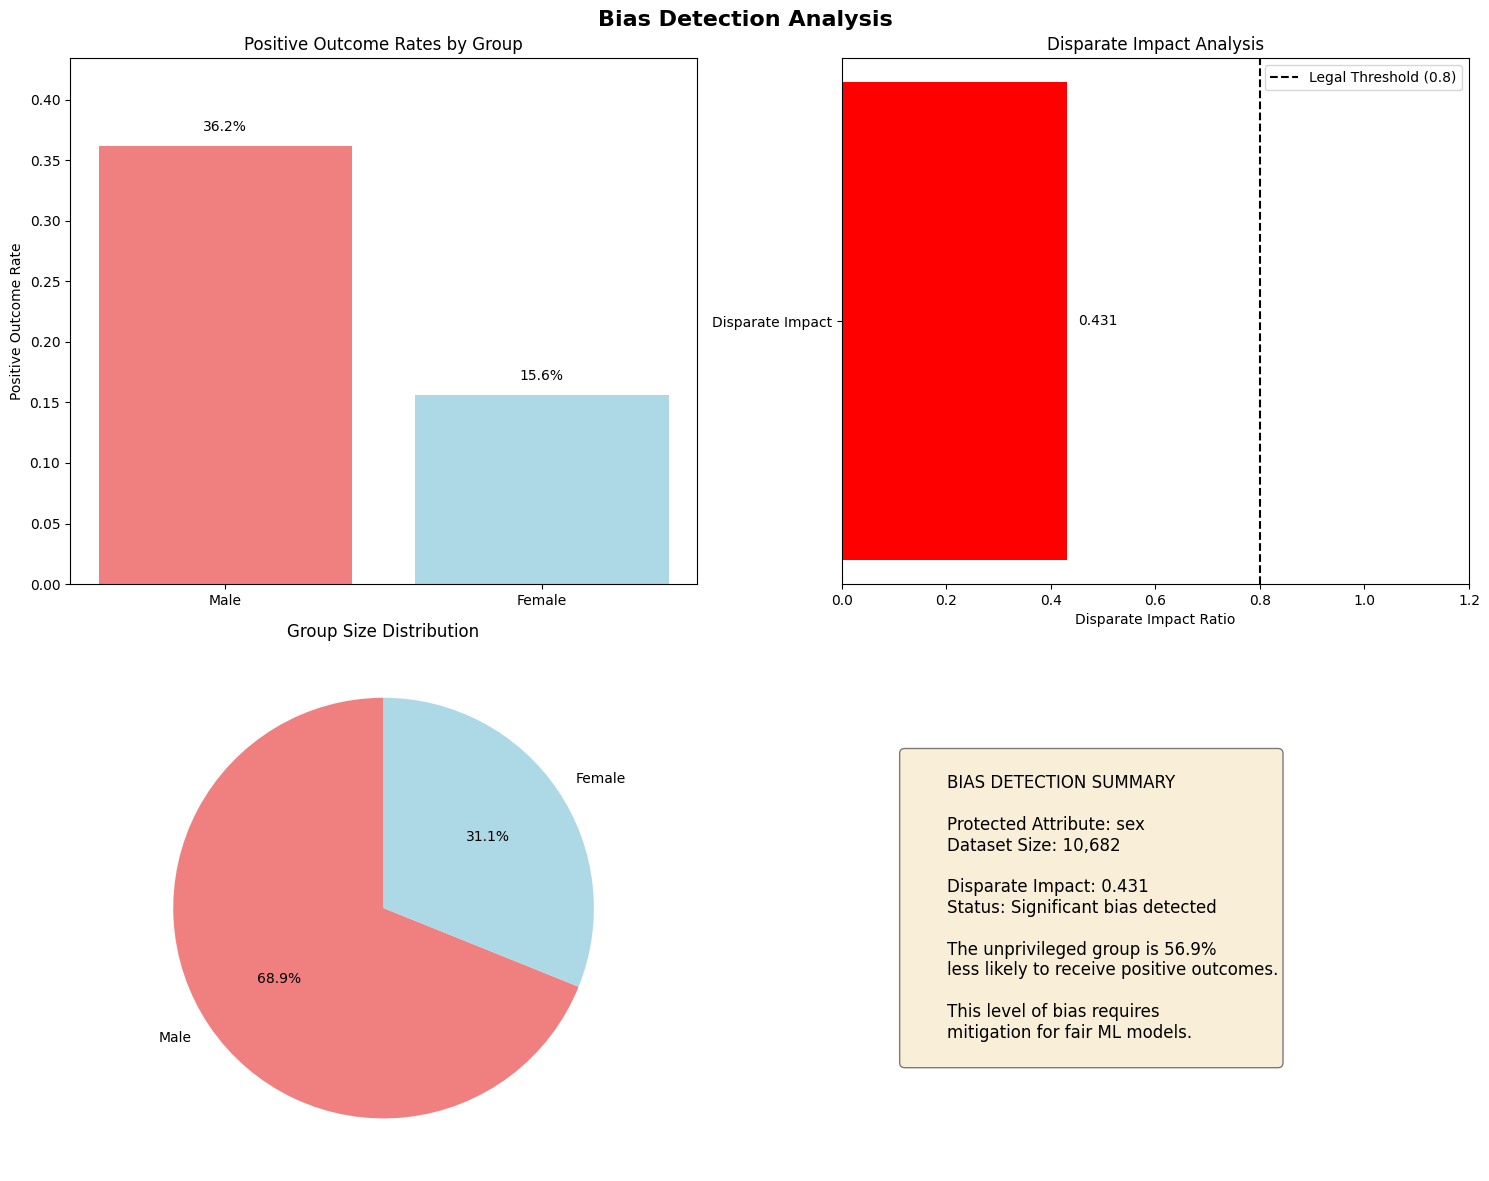



APPLYING FAIRNESS-AWARE SMOTE
Using gender column: 'sex'


/home/jsalarzai/Desktop/development/REBALANCE/notebooks/../src/fairness_smote/fair_smote.py:135: UserWarning: X is not a pandas DataFrame. Assuming protected attribute is in column 0
  warnings.warn(
/home/jsalarzai/Desktop/development/REBALANCE/notebooks/../src/fairness_smote/fair_smote.py:273: UserWarning: Not enough positive samples in group 18 for SMOTE (found 0). Skipping.
  warnings.warn(
/home/jsalarzai/Desktop/development/REBALANCE/notebooks/../src/fairness_smote/fair_smote.py:273: UserWarning: Not enough positive samples in group 19 for SMOTE (found 0). Skipping.
  warnings.warn(
/home/jsalarzai/Desktop/development/REBALANCE/notebooks/../src/fairness_smote/fair_smote.py:273: UserWarning: Not enough positive samples in group 20 for SMOTE (found 0). Skipping.
  warnings.warn(
/home/jsalarzai/Desktop/development/REBALANCE/notebooks/../src/fairness_smote/fair_smote.py:273: UserWarning: Not enough positive samples in group 21 for SMOTE (found 0). Skipping.
  warnings.warn(
/home/js


FAIRNESS-AWARE RESAMPLING SUMMARY

Original dataset:
  Total samples: 10,682
  Positive samples: 3,180 (29.8%)

  Positive class gender distribution:
    1: 2662 (83.7%)
    0: 518 (16.3%)

Resampled dataset:
  Total samples: 18,135
  Positive samples: 10,633 (58.6%)
  Synthetic samples created: 7,453

  Positive class gender distribution:
    1: 7528 (70.8%)
    0: 3105 (29.2%)



BIAS ANALYSIS AFTER FAIRNESS-AWARE SMOTE
Disparate Impact: 0.853
Statistical Parity Difference: -0.090

Disparate Impact Improvement: 97.9%


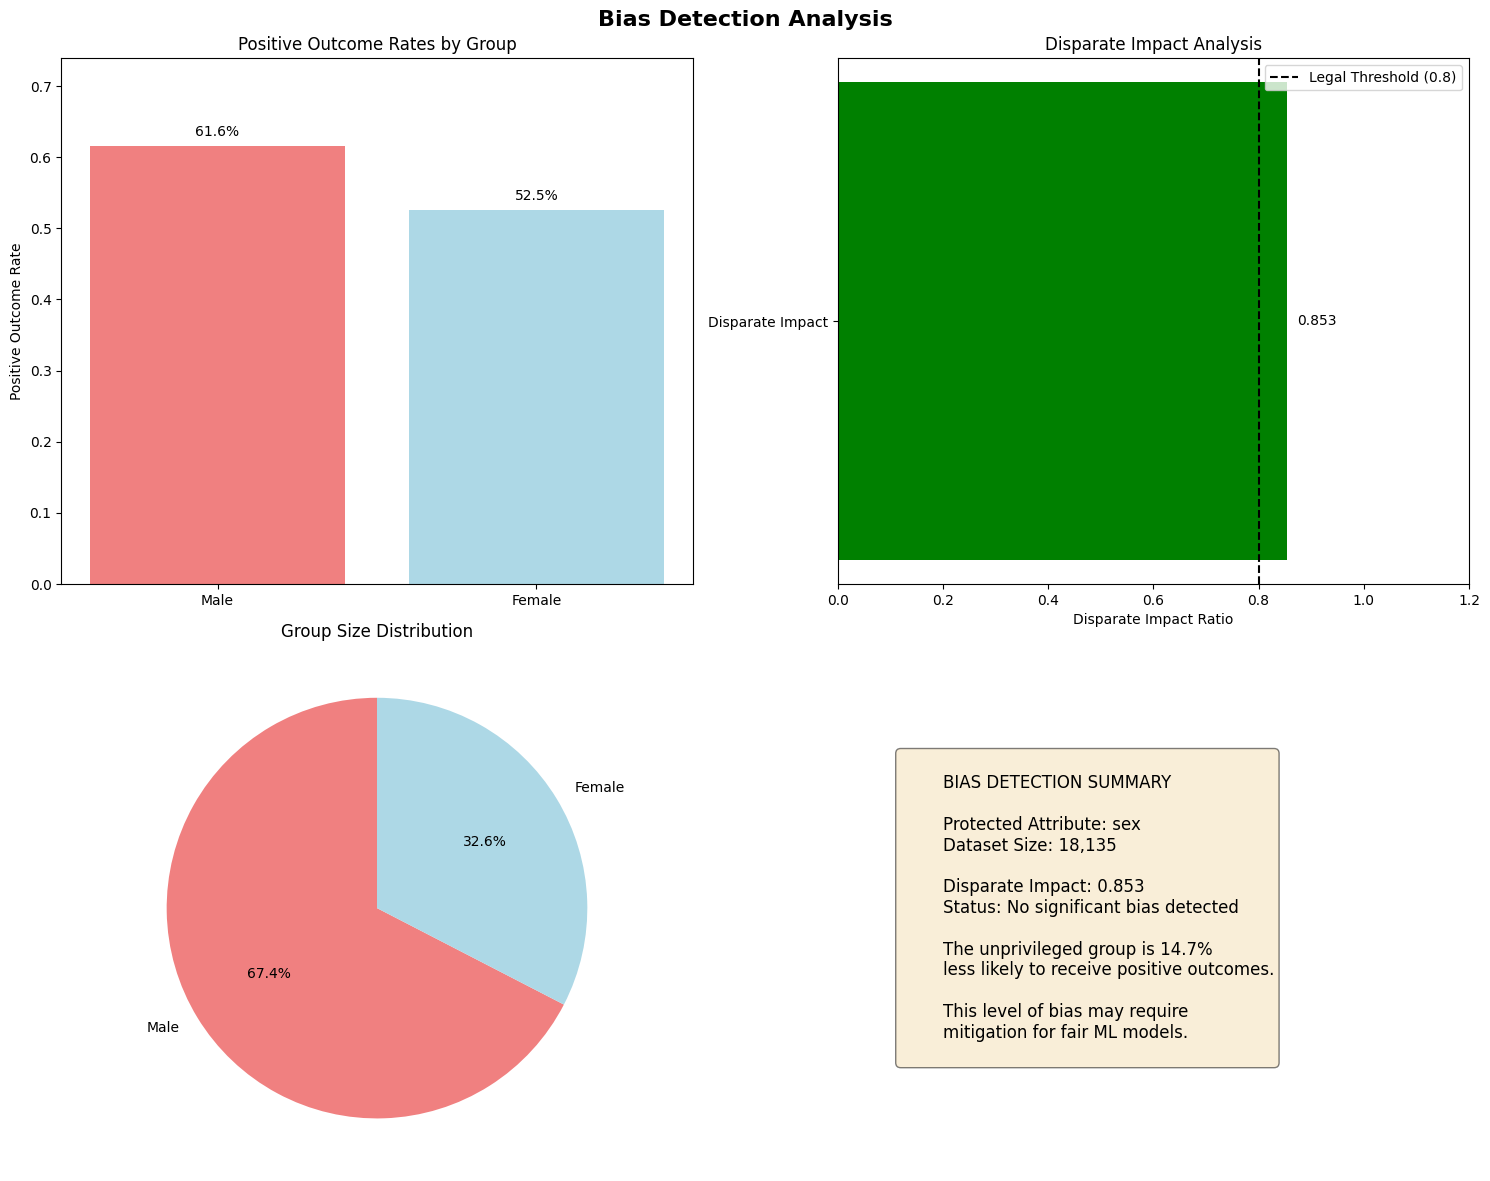



COMPARISON WITH STANDARD SMOTE
Standard SMOTE - Disparate Impact: 0.721
Fair SMOTE - Disparate Impact: 0.853


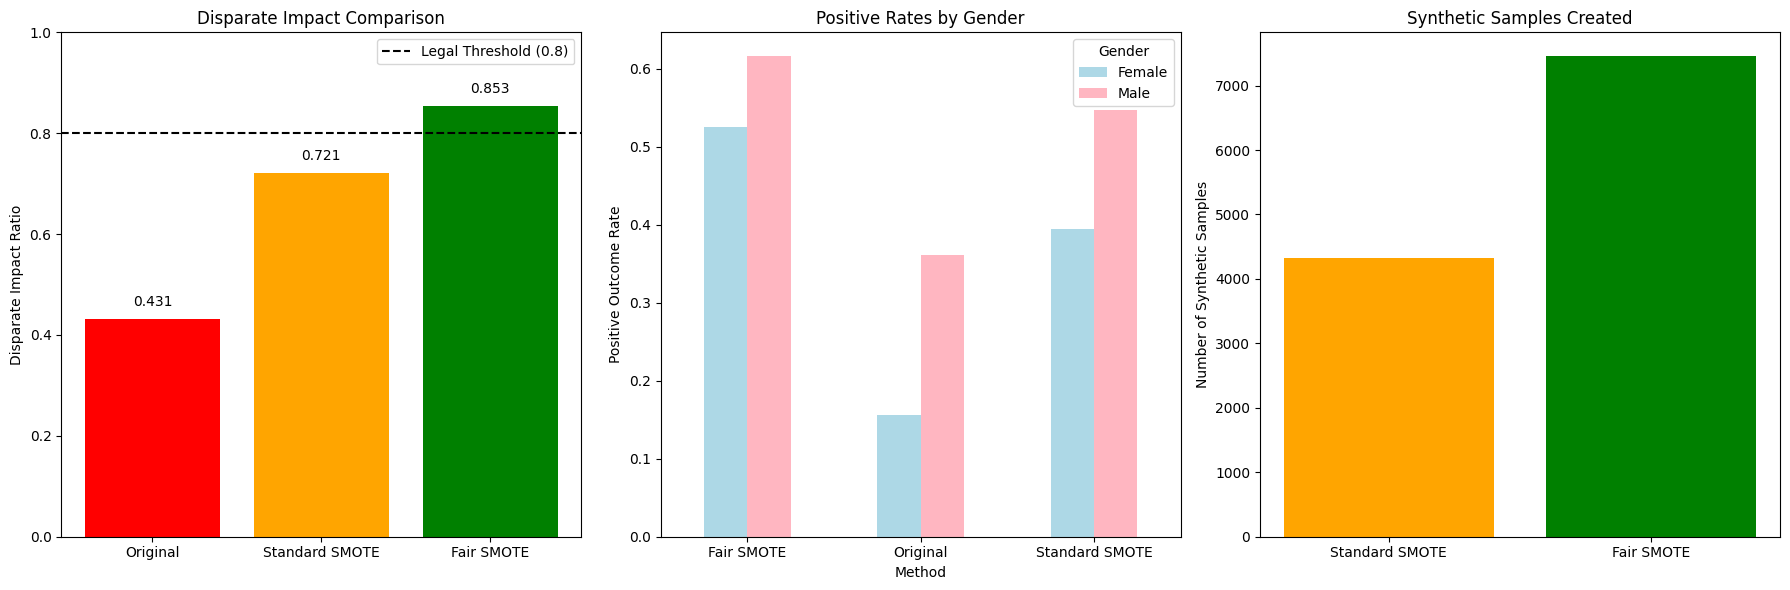



SYNTHETIC SAMPLE ANALYSIS
Total synthetic samples created: 7453
Synthetic positive samples: 7453
Synthetic negative samples: 0

Gender distribution in synthetic positive samples:
  Male: 4866 (65.3%)
  Female: 2587 (34.7%)

Top occupations in synthetic high-income women:
occupation
Prof-specialty       652
Exec-managerial      418
Priv-house-serv      201
Machine-op-inspct    193
Farming-fishing      187
Name: count, dtype: int64


In [28]:
# File: notebooks/05_test_fairness_aware_smote.ipynb

# Cell 1: Setup and Load Data
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
from src.fairness_smote.simple_fair_smote import SimpleFairSMOTE
from src.bias_detection.detector import BiasDetector
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('../data/processed/adult_with_labels.csv')

# For testing, let's use a subset that clearly shows bias
test_data = data[data['education'].isin(['Bachelors', 'Masters'])].copy()
X = test_data.drop(columns=['income', 'high_income', 'is_female_high_income'])
y = test_data['high_income']

print(f"Test dataset size: {len(test_data)}")
print(f"Class distribution: {y.value_counts().to_dict()}")

# Cell 2: Measure Original Bias
detector = BiasDetector(verbose=False)

print("ORIGINAL BIAS ANALYSIS")
print("="*50)
original_metrics = detector.detect_bias(X, y, protected_attribute='sex', positive_label=1)
print(f"Disparate Impact: {original_metrics.disparate_impact:.3f}")
print(f"Statistical Parity Difference: {original_metrics.statistical_parity_difference:.3f}")

# Visualize original bias
detector.visualize_bias(save_path='../results/figures/original_bias.png')

# Cell 3: Apply Fairness-Aware SMOTE
from sklearn.preprocessing import LabelEncoder

print("\n\nAPPLYING FAIRNESS-AWARE SMOTE")
print("="*50)

# Encode categorical features for Fair SMOTE
# We need to convert categorical columns to numeric values because SMOTE algorithms
# calculate distances between points, which requires numeric data
X_encoded_fair = X.copy()
encoders_fair = {}

# Find all categorical (object type) columns and encode them
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded_fair[col] = le.fit_transform(X[col])
    encoders_fair[col] = le  # Save encoder for later decoding

# Apply Fair SMOTE on encoded data
fair_smote = SimpleFairSMOTE(k_neighbors=5, random_state=42)
X_fair_encoded, y_fair = fair_smote.fit_resample(X_encoded_fair, y)

# Decode back to original categorical values for interpretability
X_fair = X_fair_encoded.copy()
for col, le in encoders_fair.items():
    # Convert back to int to ensure proper decoding, then to original labels
    X_fair[col] = le.inverse_transform(X_fair_encoded[col].astype(int))

# Convert back to DataFrame with original column names and structure
X_fair = pd.DataFrame(X_fair, columns=X.columns)

# Cell 4: Measure Bias After Fair SMOTE
print("\n\nBIAS ANALYSIS AFTER FAIRNESS-AWARE SMOTE")
print("="*50)
fair_metrics = detector.detect_bias(X_fair, y_fair, protected_attribute='sex', positive_label=1)
print(f"Disparate Impact: {fair_metrics.disparate_impact:.3f}")
print(f"Statistical Parity Difference: {fair_metrics.statistical_parity_difference:.3f}")

# Calculate improvement
di_improvement = (fair_metrics.disparate_impact - original_metrics.disparate_impact) / original_metrics.disparate_impact * 100
print(f"\nDisparate Impact Improvement: {di_improvement:.1f}%")

# Visualize improved bias
detector.visualize_bias(save_path='../results/figures/fair_smote_bias.png')

# Cell 5: Compare with Standard SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

print("\n\nCOMPARISON WITH STANDARD SMOTE")
print("="*50)

# Prepare data for standard SMOTE (needs encoding)
X_encoded = X.copy()
encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    encoders[col] = le

# Apply standard SMOTE
standard_smote = SMOTE(random_state=42, k_neighbors=5)
X_standard, y_standard = standard_smote.fit_resample(X_encoded, y)

# Decode back
X_standard_decoded = X_standard.copy()
for col, le in encoders.items():
    X_standard_decoded[col] = le.inverse_transform(X_standard[col].astype(int))
X_standard_decoded = pd.DataFrame(X_standard_decoded, columns=X.columns)

# Measure bias after standard SMOTE
standard_metrics = detector.detect_bias(X_standard_decoded, y_standard, 
                                       protected_attribute='sex', positive_label=1)
print(f"Standard SMOTE - Disparate Impact: {standard_metrics.disparate_impact:.3f}")
print(f"Fair SMOTE - Disparate Impact: {fair_metrics.disparate_impact:.3f}")

# Cell 6: Visualize the Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods = ['Original', 'Standard SMOTE', 'Fair SMOTE']
disparate_impacts = [
    original_metrics.disparate_impact,
    standard_metrics.disparate_impact,
    fair_metrics.disparate_impact
]

# Bar chart of disparate impacts
bars = axes[0].bar(methods, disparate_impacts, 
                   color=['red', 'orange', 'green'])
axes[0].axhline(y=0.8, color='black', linestyle='--', 
                label='Legal Threshold (0.8)')
axes[0].set_ylabel('Disparate Impact Ratio')
axes[0].set_title('Disparate Impact Comparison')
axes[0].set_ylim(0, 1.0)
axes[0].legend()

# Add value labels on bars
for bar, value in zip(bars, disparate_impacts):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.3f}', ha='center', va='bottom')

# Positive rates by gender for each method
all_data = [
    (X, y, 'Original'),
    (X_standard_decoded, y_standard, 'Standard SMOTE'),
    (X_fair, y_fair, 'Fair SMOTE')
]

gender_rates = []
for X_data, y_data, method in all_data:
    for gender in ['Male', 'Female']:
        mask = X_data['sex'] == gender
        rate = y_data[mask].mean()
        gender_rates.append({
            'Method': method,
            'Gender': gender,
            'Positive Rate': rate
        })

gender_rates_df = pd.DataFrame(gender_rates)
gender_pivot = gender_rates_df.pivot(index='Method', columns='Gender', values='Positive Rate')

gender_pivot.plot(kind='bar', ax=axes[1], color=['lightblue', 'lightpink'])
axes[1].set_ylabel('Positive Outcome Rate')
axes[1].set_title('Positive Rates by Gender')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].legend(title='Gender')

# Synthetic samples created
synthetic_counts = [
    0,  # Original
    len(y_standard) - len(y),  # Standard SMOTE
    len(y_fair) - len(y)  # Fair SMOTE
]

axes[2].bar(methods[1:], synthetic_counts[1:], color=['orange', 'green'])
axes[2].set_ylabel('Number of Synthetic Samples')
axes[2].set_title('Synthetic Samples Created')

plt.tight_layout()
plt.savefig('../results/figures/smote_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Cell 7: Detailed Analysis of Synthetic Samples
# Let's look at what kind of synthetic samples were created

# Identify synthetic samples (those added after original data)
synthetic_start_idx = len(X)
synthetic_mask = np.zeros(len(X_fair), dtype=bool)
synthetic_mask[synthetic_start_idx:] = True

synthetic_data = X_fair[synthetic_mask]
synthetic_labels = y_fair[synthetic_mask]

print("\n\nSYNTHETIC SAMPLE ANALYSIS")
print("="*50)
print(f"Total synthetic samples created: {len(synthetic_data)}")
print(f"Synthetic positive samples: {synthetic_labels.sum()}")
print(f"Synthetic negative samples: {len(synthetic_labels) - synthetic_labels.sum()}")

# Gender distribution in synthetic positive samples
synthetic_positive = synthetic_data[synthetic_labels == 1]
synthetic_gender_dist = synthetic_positive['sex'].value_counts()
print(f"\nGender distribution in synthetic positive samples:")
for gender, count in synthetic_gender_dist.items():
    print(f"  {gender}: {count} ({count/len(synthetic_positive)*100:.1f}%)")

# Most common occupations in synthetic female positive samples
if 'Female' in synthetic_gender_dist.index:
    synthetic_female_positive = synthetic_positive[synthetic_positive['sex'] == 'Female']
    print(f"\nTop occupations in synthetic high-income women:")
    print(synthetic_female_positive['occupation'].value_counts().head())

